<a href="https://colab.research.google.com/github/sanjanb/RecurrentNeuralNetwork/blob/main/RNN_Predicting_Stock_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup Environment

In [ ]:
!pip install keras tensorflow pandas matplotlib scikit-learn

##Load & Split Stock Data

Date     object
Price     int64
dtype: object
       Date  Price
0  1/4/2021    269
1  1/5/2021    271
2  1/6/2021    263
3  1/7/2021    269
4  1/8/2021    268


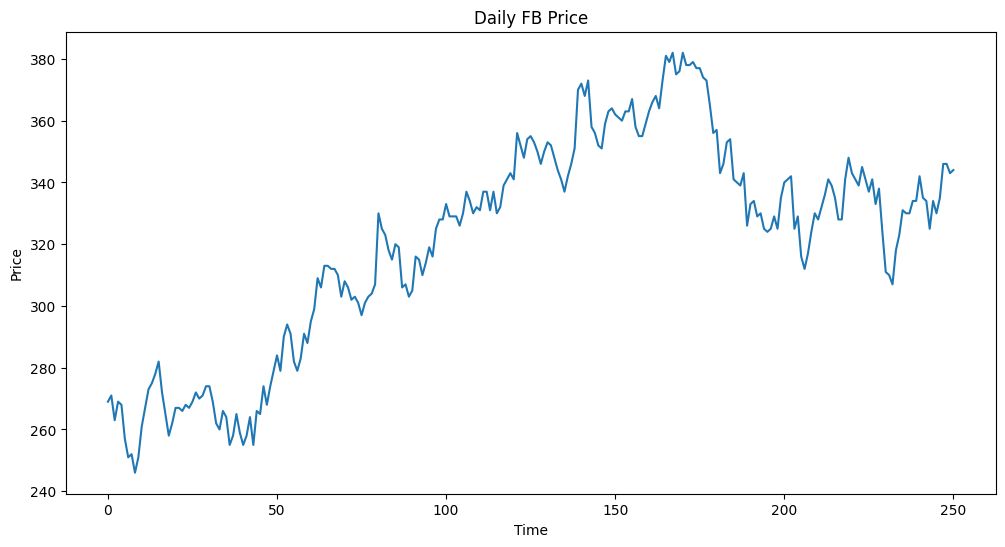

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the stock price data (ensure 'FB-stock-prices.csv' is uploaded to Colab)
prices = pd.read_csv('/content/sample_data/FB-stock-prices.csv')

# Display basic info
print(prices.dtypes)
print(prices.head())

# Plot the stock prices
plt.figure(figsize=(12,6))
plt.title("Daily FB Price")
plt.plot(prices["Price"])
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()


 ## Preprocess and Split Data

In [4]:
# Scale the 'Price' column
scaler = StandardScaler()
scaled_prices = scaler.fit_transform(prices[["Price"]].values)

total_size = len(scaled_prices)
test_size = 50
train_size = total_size - test_size

# Split data into training and test sets
training_prices = scaled_prices[:train_size]
test_prices = scaled_prices[train_size:]
print("Training shape:", training_prices.shape, "Test shape:", test_prices.shape)


Training shape: (201, 1) Test shape: (50, 1)


## Create RNN Dataset

In [5]:
def create_rnn_dataset(data, lookback=1):
    data_x, data_y = [], []
    for i in range(len(data) - lookback - 1):
        data_x.append(data[i:(i+lookback), 0])
        data_y.append(data[i + lookback, 0])
    return np.array(data_x), np.array(data_y)

lookback = 25
train_x, train_y = create_rnn_dataset(training_prices, lookback)
# Reshape for RNN input: (samples, timesteps, features)
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
print("Train X shape:", train_x.shape, "Train Y shape:", train_y.shape)

Train X shape: (175, 1, 25) Train Y shape: (175,)


## Build and Train the RNN Model

In [6]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

tf.random.set_seed(3)

# Build the model
model = Sequential()
model.add(SimpleRNN(32, input_shape=(1, lookback)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])
model.summary()

# Train the model
history = model.fit(train_x, train_y, epochs=5, batch_size=1, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 32)                  │           1,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,889 (7.38 KB)

 Trainable params: 1,889 (7.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1677 - mse: 0.1677
Epoch 2/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0653 - mse: 0.0653
Epoch 3/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0481 - mse: 0.0481
Epoch 4/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0395 - mse: 0.0395
Epoch 5/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0341 - mse: 0.0341


## Evaluate and Visualize Model Performance

Test X shape: (24, 1, 25) Test Y shape: (24,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 0.1040 - mse: 0.1040
Test MSE: 0.10402687638998032
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


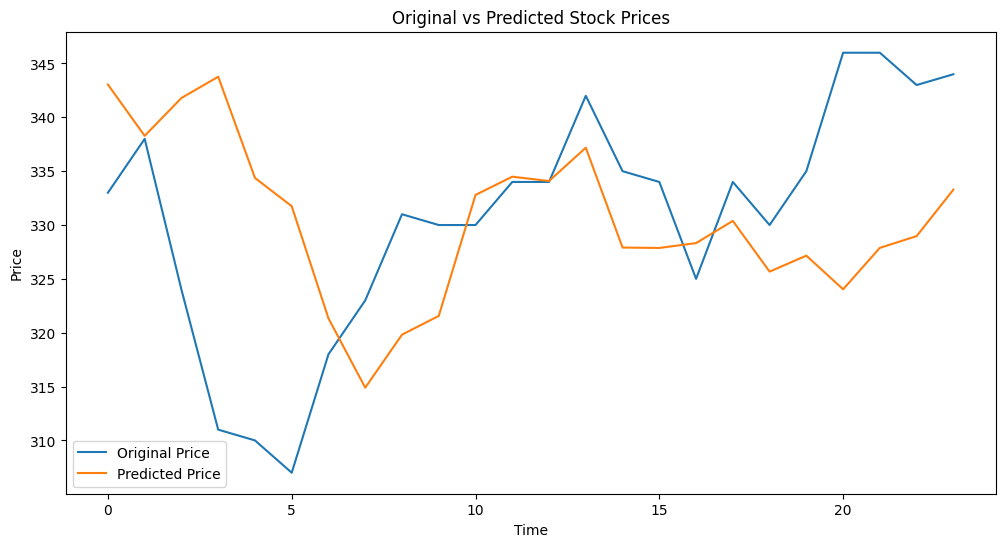

In [7]:
# Prepare test dataset similarly
test_x, test_y = create_rnn_dataset(test_prices, lookback)
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
print("Test X shape:", test_x.shape, "Test Y shape:", test_y.shape)

# Evaluate on test set
loss, mse = model.evaluate(test_x, test_y, verbose=1)
print("Test MSE:", mse)

# Predict and inverse transform predictions
predictions = model.predict(test_x)
predictions = scaler.inverse_transform(predictions)

# Get original test prices for comparison (adjusting index accordingly)
orig_test_values = prices[["Price"]].iloc[-len(predictions):].reset_index(drop=True)

plt.figure(figsize=(12,6))
plt.title("Original vs Predicted Stock Prices")
plt.plot(orig_test_values, label="Original Price")
plt.plot(predictions, label="Predicted Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


## Make a New Prediction

In [8]:
# Example previous prices (make sure these values make sense with your data)
previous_prices = np.array([325,335,340,341,342,325,329,316,312,317,
                             324,330,328,332,336,341,339,335,328,328,
                             341,348,343,341,339])
scaled_prev = scaler.transform(previous_prices.reshape(-1, 1))
# Reshape: here, we assume one prediction from a sequence of 'lookback' days
model_input = scaled_prev.reshape((1, 1, lookback))
prediction = model.predict(model_input)
predicted_price = scaler.inverse_transform(prediction)
print("The predicted stock price is:", predicted_price[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
The predicted stock price is: 330.58112
